# This Notebook comprises of Algorithm implementation and evaluation.

In [1]:
# Importing Libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as pyplot
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
# Reading in data.
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
training_data_copy = training_data.copy()

In [3]:
training_data_copy.drop('ID_code',inplace = True, axis = 1 )

In [4]:
training_data_copy.shape

(200000, 201)

In [5]:
training_set_without_target = training_data_copy.drop("target", axis=1)
training_set_with_only_target = training_data_copy["target"]

In [15]:
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(
    training_set_without_target, training_set_with_only_target, train_size=0.7, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140000, 200) (140000,)
(60000, 200) (60000,)


In [16]:
# FEature Scaling.
sc = StandardScaler()
## transforming "training"
X_train = sc.fit_transform(X_train)
## transforming "test"
X_test = sc.transform(X_test)

In [17]:
# Applying logistic regression without any regularization and on imbalanced dataset.
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

train_result = logreg.score(X_train, y_train)
test_result = logreg.score(X_test, y_test)
print("Logistic Regression Training Accuracy: %.2f%%" % (train_result*100.0))
print('*' * 100)
print("Logistic Regression Testing Accuracy: %.2f%%" % (test_result*100.0))

Logistic Regression Training Accuracy: 91.51%
****************************************************************************************************
Logistic Regression Testing Accuracy: 91.27%


In [18]:
# Implementing Confusion matrix.
cm=confusion_matrix(y_test,y_pred)
col=["Predicted Dead","Predicted Survived"]
cm=pd.DataFrame(cm)
cm.columns=["Actual 0","Actual 1"]
cm.index=["Predicted 0","Predicted 1"]
cm

,Actual 0,Actual 1
Predicted 0,53101,785
Predicted 1,4456,1658


# Note: Model Analysis
If we see our model had accuracy of >90% both on training and testing set however, if we look into confusion matrix we can see that our model has high number of false negative because our dataset is imbalanced. Hence this model makes no sense as it won't be able to predict minority class samples correctly.

In [23]:
# Evaluation Metrics.

# A) Print Precision (TP/ (TP+FP))
print("Precision score: {}".format(precision_score(y_test,y_pred)))

# B) Recall – What percent of your predictions were correct? Recall = TP/(TP+FN)

print("Recall score: {}".format(recall_score(y_test,y_pred)))

# C) F1 score – What percent of positive predictions were correct? F1 Score = 2*(Recall * Precision) / (Recall + Precision)

print("F1 Score: {}".format(f1_score(y_test,y_pred)))

Precision score: 0.6786737617683176
Recall score: 0.27118089630356557
F1 Score: 0.3875189903003389


In [20]:
# Computing Area Under Curve.
lr_auc = roc_auc_score(y_test, y_pred)

In [21]:
lr_auc

0.6283065525202643

# New strategy to balance out data - Synthetic Minority Oversampling Technique(SMOTE)
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short. This technique was described by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [6]:
# Applying SMOTE.
from collections import Counter
from numpy import where
from matplotlib import pyplot
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.7)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X1, y1 = pipeline.fit_resample(training_set_without_target,training_set_with_only_target)
# summarize the new class distribution
counter = Counter(y1)
print(counter)

Counter({0: 102800, 1: 71960})


# New target variable distribution.
Old distribution aprrox 1:10
New distribution aprrox 7:10

We can clearly see we have generated enough sample points for minortiy class and now let's see how our algorithm is performing on this new distribution.

In [7]:
# Performing Train Test Split.
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, train_size=0.7, test_size=0.3, random_state=0)

print(X_train1.shape, y_train1.shape)
print(X_test1.shape, y_test1.shape)

(122331, 200) (122331,)
(52428, 200) (52428,)


In [8]:
# Performing Feature Scaling.
sc = StandardScaler()

## transforming "training"
X_train1 = sc.fit_transform(X_train1)
## transforming "test"
X_test1 = sc.transform(X_test1)

In [9]:
# Applying Logistic Regression on balanced dataset along with it we are using lasso Regularization 
# so as to minimize the effect of unnecessary predictors.

logreg1 = LogisticRegression(penalty='l1', solver='saga')

logreg1.fit(X_train1,y_train1)

y_pred1 = logreg1.predict(X_test1)

train_result1 = logreg1.score(X_train1, y_train1)
test_result1 = logreg1.score(X_test1, y_test1)
print("Logistic Regression Training Accuracy: %.2f%%" % (train_result1*100.0))
print('*' * 100)
print("Logistic Regression Testing Accuracy: %.2f%%" % (test_result1*100.0))

Logistic Regression Training Accuracy: 79.92%
****************************************************************************************************
Logistic Regression Testing Accuracy: 79.87%


In [10]:
cm=confusion_matrix(y_test1,y_pred1)
col=["Predicted Dead","Predicted Survived"]
cm=pd.DataFrame(cm)
cm.columns=["Actual 0","Actual 1"]
cm.index=["Predicted 0","Predicted 1"]
cm

,Actual 0,Actual 1
Predicted 0,26009,4659
Predicted 1,5895,15865


# Note: Model Analysis
If we see our new model it has reduced the number of false negatives and is better at predicting minority class.

In [11]:
# Computing Area Under Curve
lr_auc = roc_auc_score(y_test1, y_pred1)

In [12]:
lr_auc

0.7885863827931394

# If we compare AUC with original model there is a significant improvement.

In [24]:
# Evaluating Metrics
print("Precision score: {}".format(precision_score(y_test1,y_pred1)))

# B) Recall – What percent of your predictions were correct? Recall = TP/(TP+FN)

print("Recall score: {}".format(recall_score(y_test1,y_pred1)))

# C) F1 score – What percent of positive predictions were correct? F1 Score = 2*(Recall * Precision) / (Recall + Precision)

print("F1 Score: {}".format(f1_score(y_test1,y_pred1)))

Precision score: 0.7729974663808225
Recall score: 0.7290900735294118
F1 Score: 0.7504020433260808


# There has been a significant improvement in Recall and F1 score as compared to original model.

# Let's plot ROC Curve for both models.

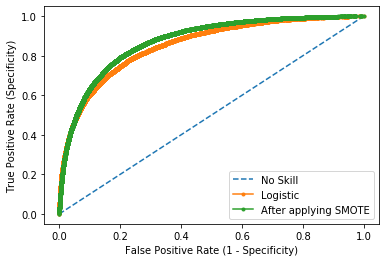

In [22]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
y_pred_proba = logreg.predict_proba(X_test) # because roc curve needs actual labels and predicted probabilities
clf_pred_proba = logreg1.predict_proba(X_test1) # because roc curve needs actual labels and predicted probabilities


# keep probabilities for the positive outcome only
y_pred_proba = y_pred_proba[:, 1]
clf_pred_proba = clf_pred_proba[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba)
lr_fpr1, lr_tpr1, _ = roc_curve(y_test1, clf_pred_proba)


# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(lr_fpr1, lr_tpr1, marker='.', label='After applying SMOTE')


# axis labels
pyplot.xlabel('False Positive Rate (1 - Specificity)')
pyplot.ylabel('True Positive Rate (Specificity)')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Conclusion-
We can conclude that algorithms like Logistic Regression are inefficient at handling imbalanced data and SMOTE technique proves to be very efficient when trying to balance out data it alos help's model to predict minority class efficiently.

In [25]:
# Final Predictions on Validation set.

validation_set = test_data.copy()

In [27]:
validation_set.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [28]:
validation_set.drop('ID_code', axis =1, inplace = True)

In [29]:
validation_set.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [31]:
# Feature Scaling.
validation_set_scaling = sc.transform(validation_set)

In [32]:
final_pred = logreg1.predict(validation_set_scaling)

In [33]:
submission =  test_data.copy()
submission['Final Predictions'] = final_pred
# FinalLogisticPredictions.Survived = FinalLogisticPredictions.Survived.astype(int)

submission.to_csv("ValidationPredictions.csv")
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [34]:
validation_check = pd.read_csv('ValidationPredictions.csv')

In [38]:
validation_check[['ID_code', 'Final Predictions']].head()

,ID_code,Final Predictions
0,test_0,1
1,test_1,1
2,test_2,0
3,test_3,1
4,test_4,0


In [42]:
# Saving Model
from joblib import dump, load
filename1 = 'logistic_model.sav'
filename2 = 'SMOTE_Logistic_Model.sav'

In [44]:
dump(logreg, 'Logistic_model.sav') 

['Logistic_model.sav']

In [45]:
dump(logreg1, 'SMOTE_Logistic_model.sav') 

['SMOTE_Logistic_model.sav']